In [1]:
"""
Want to embed chief complaints.
chiefcomplaints = (
    ed_triage["chiefcomplaint"]
    .fillna("UNSPECIFIED")
    .str.split(",")
    .explode()
    .str.strip()
    .replace("", "UNSPECIFIED")
    .str.title()
)
https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT
The Bio_ClinicalBERT model was trained on all notes from MIMIC III, a database containing electronic health records from ICU patients at the Beth Israel Hospital in Boston, MA. For more details on MIMIC, see here. All notes from the NOTEEVENTS table were included (~880M words).
https://mimic.mit.edu/docs/iii/tables/noteevents/
"""

'\nWant to embed chief complaints.\nchiefcomplaints = (\n    ed_triage["chiefcomplaint"]\n    .fillna("UNSPECIFIED")\n    .str.split(",")\n    .explode()\n    .str.strip()\n    .replace("", "UNSPECIFIED")\n    .str.title()\n)\nhttps://huggingface.co/emilyalsentzer/Bio_ClinicalBERT\nThe Bio_ClinicalBERT model was trained on all notes from MIMIC III, a database containing electronic health records from ICU patients at the Beth Israel Hospital in Boston, MA. For more details on MIMIC, see here. All notes from the NOTEEVENTS table were included (~880M words).\nhttps://mimic.mit.edu/docs/iii/tables/noteevents/\n'

In [2]:
import sys
from pathlib import Path

def find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / 'pyproject.toml').exists():
            return p
    raise FileNotFoundError('pyproject.toml not found')

repo_root = find_repo_root(Path.cwd().resolve())
sys.path.append(str(repo_root))
from src.data.preprocessing import load_processed_ed_data 

ed_triage = load_processed_ed_data()
# grab top chief complaints
chiefcomplaints = (
    ed_triage["chiefcomplaint"]
    .fillna("UNSPECIFIED")
    .str.split(",")
    .explode()
    .str.strip()
    .replace("", "UNSPECIFIED")
    .str.title()
)
top_chiefcomplaints = chiefcomplaints.value_counts().head(30)

<class 'pandas.DataFrame'>


In [3]:
print(top_chiefcomplaints)

chiefcomplaint
Abd Pain                 33480
Chest Pain               26798
Transfer                 23273
S/P Fall                 21220
Dyspnea                  18645
Headache                 13413
Fever                    12677
Etoh                     10464
Back Pain                 9954
Dizziness                 9361
Weakness                  9269
N/V                       9153
Si                        8079
Wound Eval                7609
Cough                     7508
Altered Mental Status     5910
Mvc                       5725
Lower Back Pain           5286
Syncope                   5176
Abnormal Labs             5168
Ili                       5008
Nausea                    4827
Sore Throat               4363
Palpitations              4321
N/V/D                     4183
Neck Pain                 4113
Brbpr                     4109
Vomiting                  4023
Diarrhea                  3935
Seizure                   3759
Name: count, dtype: int64


In [4]:
test_data = [
    ("Abd Pain", "Abdominal Pain"),
    ("Chest Pain", "Chest Pain"),
    ("Transfer", "Transfer from another facility"),
    ("S/P Fall", "Status Post Fall (History of Fall)"),
    ("Dyspnea", "Shortness of Breath"),
    ("Headache", "Headache"),
    ("Fever", "Fever"),
    ("Etoh", "Alcohol Intoxication or Withdrawal"),
    ("Back Pain", "Back Pain"),
    ("Dizziness", "Dizziness or Vertigo"),
    ("Weakness", "General Weakness"),
    ("N/V", "Nausea and Vomiting"),
    ("Si", "Suicidal Ideation"),
    ("Wound Eval", "Wound Evaluation"),
    ("Cough", "Cough"),
]

In [ ]:
from sentence_transformers import SentenceTransformer, util

# SapBERT
model_sap = SentenceTransformer('cambridgeltl/SapBERT-from-PubMedBERT-fulltext')

# Bio_ClinicalBERT
model_clin = SentenceTransformer('emilyalsentzer/Bio_ClinicalBERT')


In [ ]:
print(f"{'TERM':<10} | {'TARGET':<25} | {'SAP SCORE':<10} | {'CLIN SCORE':<10}")
print("-" * 65)

scores_sap = []
scores_clin = []

for item in test_data:
    term, target = item
    
    # Encode with SapBERT
    e_sap = model_sap.encode([term, target])
    score_sap = util.cos_sim(e_sap[0], e_sap[1]).item()
    scores_sap.append(score_sap)
    
    # Encode with ClinicalBERT
    e_clin = model_clin.encode([term, target])
    score_clin = util.cos_sim(e_clin[0], e_clin[1]).item()
    scores_clin.append(score_clin)
    
    print(f"{term:<10} | {target:<25} | {score_sap:.4f}     | {score_clin:.4f}")

# EXPECTED RESULT:
# ClinicalBERT should win on 'Si', 'Etoh', 'S/P Fall'.
# SapBERT should win (or tie high) on 'Dyspnea', 'Abd Pain'.

TERM       | TARGET                    | SAP SCORE  | CLIN SCORE
-----------------------------------------------------------------
Abd Pain   | Abdominal Pain            | 0.7740     | 0.9249
Chest Pain | Chest Pain                | 1.0000     | 1.0000
Transfer   | Transfer from another facility | 0.7035     | 0.7733
S/P Fall   | Status Post Fall (History of Fall) | 0.6957     | 0.8784
Dyspnea    | Shortness of Breath       | 0.7255     | 0.8902
Headache   | Headache                  | 1.0000     | 1.0000
Fever      | Fever                     | 1.0000     | 1.0000
Etoh       | Alcohol Intoxication or Withdrawal | 0.6636     | 0.8139
Back Pain  | Back Pain                 | 1.0000     | 1.0000
Dizziness  | Dizziness or Vertigo      | 0.8987     | 0.9214
Weakness   | General Weakness          | 0.9297     | 0.9029
N/V        | Nausea and Vomiting       | 0.4244     | 0.7761
Si         | Suicidal Ideation         | 0.4881     | 0.6269
Wound Eval | Wound Evaluation          | 0.8128     |

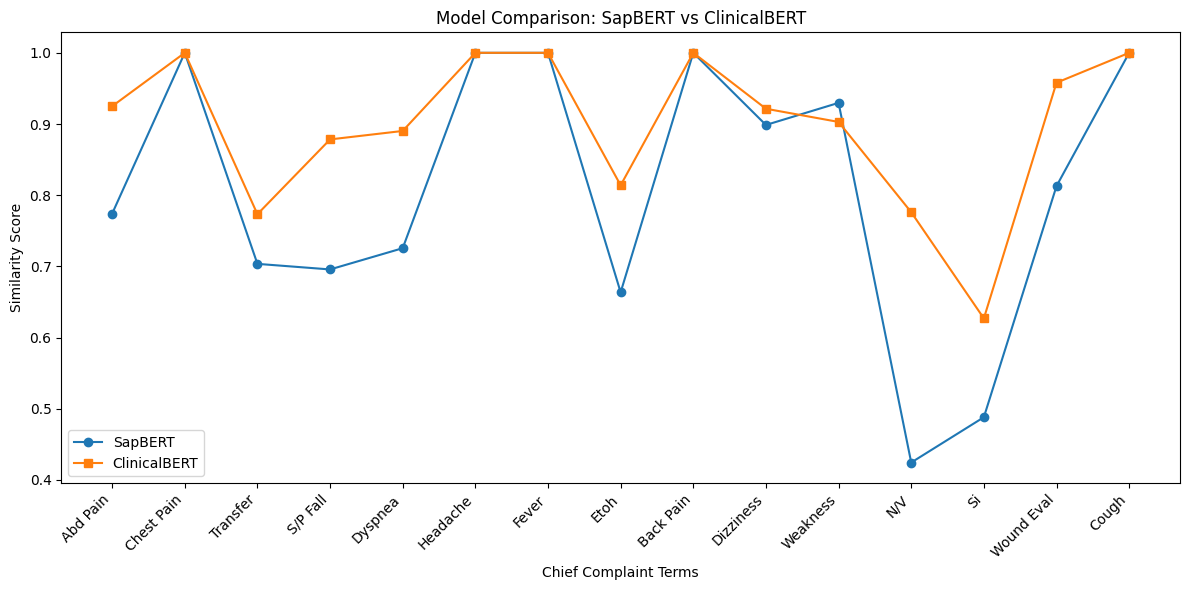

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot([item[0] for item in test_data], scores_sap, marker='o', label='SapBERT')
plt.plot([item[0] for item in test_data], scores_clin, marker='s', label='ClinicalBERT')
plt.xlabel('Chief Complaint Terms')
plt.ylabel('Similarity Score')
plt.title('Model Comparison: SapBERT vs ClinicalBERT')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

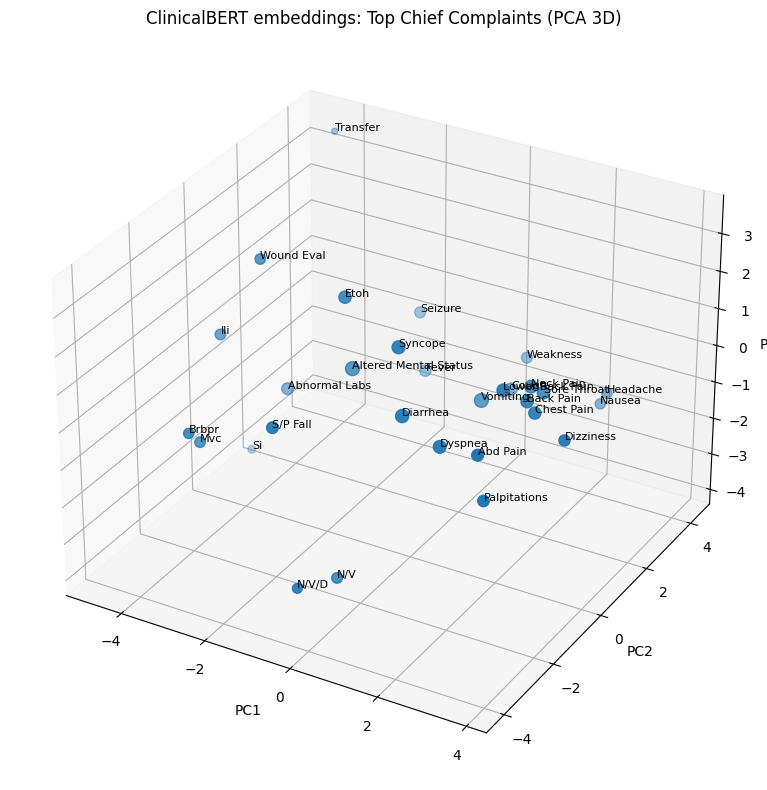

In [ ]:
# Using ClinicalBERT, make a 3D projection plot of the top keywords
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Prepare keywords and embeddings
keywords = list(top_chiefcomplaints.index)
embeddings = model_clin.encode(keywords)

# Reduce to 3D with PCA
pca = PCA(n_components=3)
proj = pca.fit_transform(embeddings)

# 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Make points farther from the origin smaller
dists = (proj**2).sum(axis=1) ** 0.5
sizes = 80 * (1 - (dists - dists.min()) / (dists.ptp() + 1e-9)) + 20
ax.scatter(proj[:, 0], proj[:, 1], proj[:, 2], s=sizes)

for i, word in enumerate(keywords):
    ax.text(proj[i, 0], proj[i, 1], proj[i, 2], word, fontsize=8)

ax.set_title('ClinicalBERT embeddings: Top Chief Complaints (PCA 3D)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.tight_layout()
plt.show()


In [ ]:
# Pairwise distances between embeddings of top_chiefcomplaints; show top 30 closest pairs
import numpy as np

labels = list(top_chiefcomplaints.index)
emb = model_clin.encode(labels)

pairs = []
for i in range(len(labels)):
    for j in range(i + 1, len(labels)):
        dist = np.linalg.norm(emb[i] - emb[j])
        pairs.append((dist, labels[i], labels[j]))

pairs.sort(key=lambda x: x[0])

print(f"Top 30 closest pairs (out of {len(pairs)} total):")
for dist, a, b in pairs[:30]:
    print(f"{a:<25} | {b:<25} | {dist:.4f}")


Top 30 closest pairs (out of 435 total):
Back Pain                 | Lower Back Pain           | 3.0442
N/V                       | N/V/D                     | 3.3549
Back Pain                 | Neck Pain                 | 3.8800
Lower Back Pain           | Neck Pain                 | 4.2070
Chest Pain                | Neck Pain                 | 4.3991
Chest Pain                | Back Pain                 | 4.6005
Sore Throat               | Neck Pain                 | 4.7025
Chest Pain                | Lower Back Pain           | 4.7408
Chest Pain                | Dizziness                 | 5.0112
Abd Pain                  | Lower Back Pain           | 5.1240
Dizziness                 | Lower Back Pain           | 5.2681
Headache                  | Nausea                    | 5.3705
Chest Pain                | Sore Throat               | 5.3809
Headache                  | Neck Pain                 | 5.4629
Lower Back Pain           | Sore Throat               | 5.4883
Dyspnea       